In [1]:
import h5py
import numpy as np
import shutil

from misc_utils.tensor_sampling_utils import sample_tensors

In [2]:
# TODO: Set the path for the source weights file you want to load.
# 이 부분은 경로를 직접 입력해야 함
weights_source_path = 'C:\\Users\\user\\Desktop\\weight\\VGG_VOC0712Plus_SSD_300x300_iter_240000.h5'

# TODO: Set the path and name for the destination weights file
#       that you want to create.
# 이 부분은 경로를 직접 입력해야 함
weights_destination_path = 'C:\\Users\\user\\Desktop\\weight\\VGG_VOC0712Plus_SSD_300x300_iter_240000_sampling_2_.h5'

# Make a copy of the weights file.
shutil.copy(weights_source_path, weights_destination_path)

'C:\\Users\\user\\Desktop\\weight\\VGG_VOC0712Plus_SSD_300x300_iter_240000_sampling_2_.h5'

In [3]:
# Load both the source weights file and the copy we made.
# We will load the original weights file in read-only mode so that we can't mess up anything.
weights_source_file = h5py.File(weights_source_path, 'r')
weights_destination_file = h5py.File(weights_destination_path)

In [4]:
classifier_names = ['conv4_3_norm_mbox_conf',
                    'fc7_mbox_conf',
                    'conv6_2_mbox_conf',
                    'conv7_2_mbox_conf',
                    'conv8_2_mbox_conf',
                    'conv9_2_mbox_conf']

In [5]:
# 이 부분은 class 개수대로 모델이 알맞게 설계 된 건지 체크하는 영역
# 넘어가도 됨

conv4_3_norm_mbox_conf_kernel = weights_destination_file[classifier_names[0]][classifier_names[0]]['kernel:0']
conv4_3_norm_mbox_conf_bias = weights_destination_file[classifier_names[0]][classifier_names[0]]['bias:0']

print("Shape of the '{}' weights:".format(classifier_names[0]))
print()
print("kernel:\t", conv4_3_norm_mbox_conf_kernel.shape)
print("bias:\t", conv4_3_norm_mbox_conf_bias.shape)

Shape of the 'conv4_3_norm_mbox_conf' weights:

kernel:	 (3, 3, 512, 84)
bias:	 (84,)


In [6]:
# TODO: Set the number of classes in the source weights file. Note that this number must include
#       the background class, so for MS COCO's 80 classes, this must be 80 + 1 = 81.
#       PASCAL VOC를 사용했으므로 20 + 1 = 21.
n_classes_source = 21
# TODO: Set the indices of the classes that you want to pick for the sub-sampled weight tensors.
#       In case you would like to just randomly sample a certain number of classes, you can just set
#       `classes_of_interest` to an integer instead of the list below. Either way, don't forget to
#       include the background class. That is, if you set an integer, and you want `n` positive classes,
#       then you must set `classes_of_interest = n + 1`.
# class 구분은 crack or background이므로 총 2개임
classes_of_interest = 2

# classes_of_interest = 9 # Uncomment this in case you want to just randomly sub-sample the last axis instead of providing a list of indices.

for name in classifier_names:
    # Get the trained weights for this layer from the source HDF5 weights file.
    kernel = weights_source_file[name][name]['kernel:0'].value
    bias = weights_source_file[name][name]['bias:0'].value

    # Get the shape of the kernel. We're interested in sub-sampling
    # the last dimension, 'o'.
    height, width, in_channels, out_channels = kernel.shape
    
    # Compute the indices of the elements we want to sub-sample.
    # Keep in mind that each classification predictor layer predicts multiple
    # bounding boxes for every spatial location, so we want to sub-sample
    # the relevant classes for each of these boxes.
    if isinstance(classes_of_interest, (list, tuple)):
        subsampling_indices = []
        for i in range(int(out_channels/n_classes_source)):
            indices = np.array(classes_of_interest) + i * n_classes_source
            subsampling_indices.append(indices)
        subsampling_indices = list(np.concatenate(subsampling_indices))
    elif isinstance(classes_of_interest, int):
        subsampling_indices = int(classes_of_interest * (out_channels/n_classes_source))
    else:
        raise ValueError("`classes_of_interest` must be either an integer or a list/tuple.")
    
    # Sub-sample the kernel and bias.
    # The `sample_tensors()` function used below provides extensive
    # documentation, so don't hesitate to read it if you want to know
    # what exactly is going on here.
    # 이 수치들을 수정했을 때 성능에 차이가 있으려나? 한 번 알아보자
    new_kernel, new_bias = sample_tensors(weights_list=[kernel, bias],
                                          sampling_instructions=[height, width, in_channels, subsampling_indices],
                                          axes=[[3]], # The one bias dimension corresponds to the last kernel dimension.
                                          init=['gaussian', 'zeros'],
                                          mean=0.0,
                                          stddev=0.005)
    
    # Delete the old weights from the destination file.
    del weights_destination_file[name][name]['kernel:0']
    del weights_destination_file[name][name]['bias:0']
    # Create new datasets for the sub-sampled weights.
    weights_destination_file[name][name].create_dataset(name='kernel:0', data=new_kernel)
    weights_destination_file[name][name].create_dataset(name='bias:0', data=new_bias)

# Make sure all data is written to our output file before this sub-routine exits.
weights_destination_file.flush()

In [7]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.


In [8]:
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
              # 여기서는 background class를 제외한 순수 interesting class의 갯수를 의미.
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

In [9]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)

# 2: Load some weights into the model.

# TODO: Set the path to the weights you want to load.
weights_path = weights_destination_path

model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=sgd, loss=ssd_loss.compute_loss)

In [10]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.
# 속도 향상을 위해 True로 변경하였음. RAM이 받쳐주지 못한다면 False로 바꿀 것.
train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets. This can take a while.

# TODO: Set the paths to the datasets here.

# The directories that contain the images.
# 추후 Crack images 및 annotations를 augmentation 할 것
Crack_images_dir      = '../../Desktop/SPARK/Concrete Crack Images for Classification/Positive 300 X 300/Positive/'

# The directories that contain the annotations.
Crack_images_dir_annotations      = '../../Desktop/SPARK/Concrete Crack Images for Classification/Positive 300 X 300/annotation/'

# The paths to the image sets.
# 여기서 train/val/test 세트로 나눠야 함
# trainval:test의 비중을 4:1로 나눔 -> trainval인걸 보니 train 세트 내에서 자동으로 validation을 랜덤으로 진행하겠다는 건가?
# 추후 trainval/test를 랜덤하게 나눌 것

#VOC_2012_train_image_set_filename    = '../../datasets/VOCdevkit/VOC2012/ImageSets/Main/train.txt'
#VOC_2012_val_image_set_filename      = '../../datasets/VOCdevkit/VOC2012/ImageSets/Main/val.txt'

trainval_image_set_filename = '../../Desktop/SPARK/Concrete Crack Images for Classification/Positive 300 X 300/trainval.txt'
test_image_set_filename     = '../../Desktop/SPARK/Concrete Crack Images for Classification/Positive 300 X 300/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
# 나는 1개의 클래스를 사용
# non-crack을 annotation할 수는 없음. non-crack은 background class로 처리되어야 하는 게 맞음. 
# 추후 test에서 non-crack이미지도 함께 테스트 하면 됨
# 하지만 background class는 default로 여기 포함시켜야 함
classes = ['background','crack']

train_dataset.parse_xml(images_dirs=[Crack_images_dir],
                        image_set_filenames=[trainval_image_set_filename],
                        annotations_dirs=[Crack_images_dir_annotations],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs=[Crack_images_dir],
                      image_set_filenames=[test_image_set_filename],
                      annotations_dirs=[Crack_images_dir_annotations],
                      classes=classes,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.
# 나는 load_images_into_memory=True 체크 하였으므로 아래 함수는 comment out 시킴.

#train_dataset.create_hdf5_dataset(file_path='dataset_pascal_voc_07+12_trainval.h5',
#                                  resize=False,
#                                  variable_image_size=True,
#                                  verbose=True)

#val_dataset.create_hdf5_dataset(file_path='dataset_pascal_voc_07_test.h5',
#                                resize=False,
#                                variable_image_size=True,
#                                verbose=True)

Loading images into memory: 100%|█████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 459.73it/s]


In [11]:
# 3: Set the batch size.

batch_size = 4 # Change the batch size if you like, or if you run into GPU memory issues.
               # 16 -> 4로 줄임
               # 8을 넣었을 땐 에러가 났었음, 추후 다시 시도해 볼 것
               # RAM 16GB, GTX970M 기준임 
               # AWS를 이용할 땐 그에 맞게 늘릴 것
              

# 4: Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
# layer를 과제에 맞게 수정해야 하는 곳
# 추후 각자 공부한 내용을 바탕으로 layer를 수정해가며 어떤 시도가 가장 loss 값을 줄여주는 지 알아보자 
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,  # 이미지들의 train 순서를 random하게 해주는 기능 맞는지 확인
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	  8000
Number of images in the validation dataset:	  2000


In [12]:
# Define a learning rate schedule.
# epoch = 1,000 training steps
# 알맞은 Learning rate를 찾을 것
def lr_schedule(epoch):
    if epoch < 3:           
        return 0.001        
    elif epoch < 10:        
        return 0.0001

In [13]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the model.
# 추후 file path를 알맞게 수정하자
# 원래 여기서 return하는 파일은 weight가 아니라 model이다!
### 하지만 inference의 편의를 위해 여기서 Weight 만 저장하는 것으로 바꿈!!!
### 여기서 Model을 통째로 저장하면 Inference에서 굉장한 어려움을 겪음!!!
model_checkpoint = ModelCheckpoint(filepath='ssd300_pascal_07+12_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=True, ### 여기서 Weight 만 저장하는 것으로 바꿈!!!
                                   mode='auto',
                                   period=1)
#model_checkpoint.best = 

csv_logger = CSVLogger(filename='ssd300_pascal_07+12_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]

In [14]:
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
# 추후 최적화를 위해 이 부분을 수정해야 함
# 데이터의 갯수에 따라서도 각 epoch 변수를 수정해야 함
initial_epoch   = 0
final_epoch     = 8
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 1/5

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.


 310/1000 [========>.....................] - ETA: 2:43:30 - loss: 19.903 - ETA: 1:24:58 - loss: 18.695 - ETA: 58:46 - loss: 17.6357  - ETA: 45:41 - loss: 16.839 - ETA: 37:50 - loss: 18.006 - ETA: 32:35 - loss: 17.519 - ETA: 28:50 - loss: 17.196 - ETA: 26:02 - loss: 17.049 - ETA: 23:50 - loss: 16.776 - ETA: 22:06 - loss: 16.449 - ETA: 20:40 - loss: 15.667 - ETA: 19:28 - loss: 14.997 - ETA: 18:28 - loss: 14.475 - ETA: 17:35 - loss: 14.008 - ETA: 16:50 - loss: 13.606 - ETA: 16:11 - loss: 13.333 - ETA: 15:37 - loss: 12.967 - ETA: 15:06 - loss: 12.649 - ETA: 14:38 - loss: 12.516 - ETA: 14:13 - loss: 12.240 - ETA: 13:50 - loss: 12.136 - ETA: 13:29 - loss: 12.189 - ETA: 13:11 - loss: 11.961 - ETA: 12:53 - loss: 11.859 - ETA: 12:37 - loss: 11.937 - ETA: 12:22 - loss: 12.142 - ETA: 12:08 - loss: 11.929 - ETA: 11:56 - loss: 11.906 - ETA: 11:43 - loss: 12.000 - ETA: 11:32 - loss: 11.801 - ETA: 11:22 - loss: 11.671 - ETA: 11:12 - loss: 11.539 - ETA: 11:03 - loss: 11.394 - ETA: 10:54 - loss: 11.235

 945/1000 [===========================>..] - ETA: 2:36 - loss: 5.570 - ETA: 2:35 - loss: 5.568 - ETA: 2:35 - loss: 5.567 - ETA: 2:35 - loss: 5.565 - ETA: 2:34 - loss: 5.564 - ETA: 2:34 - loss: 5.561 - ETA: 2:33 - loss: 5.559 - ETA: 2:33 - loss: 5.557 - ETA: 2:32 - loss: 5.558 - ETA: 2:32 - loss: 5.556 - ETA: 2:32 - loss: 5.553 - ETA: 2:31 - loss: 5.552 - ETA: 2:31 - loss: 5.549 - ETA: 2:30 - loss: 5.546 - ETA: 2:30 - loss: 5.544 - ETA: 2:29 - loss: 5.542 - ETA: 2:29 - loss: 5.540 - ETA: 2:29 - loss: 5.537 - ETA: 2:28 - loss: 5.534 - ETA: 2:28 - loss: 5.530 - ETA: 2:27 - loss: 5.528 - ETA: 2:27 - loss: 5.526 - ETA: 2:26 - loss: 5.523 - ETA: 2:26 - loss: 5.521 - ETA: 2:26 - loss: 5.517 - ETA: 2:25 - loss: 5.514 - ETA: 2:25 - loss: 5.512 - ETA: 2:24 - loss: 5.510 - ETA: 2:24 - loss: 5.508 - ETA: 2:24 - loss: 5.506 - ETA: 2:23 - loss: 5.504 - ETA: 2:23 - loss: 5.501 - ETA: 2:22 - loss: 5.499 - ETA: 2:22 - loss: 5.496 - ETA: 2:21 - loss: 5.494 - ETA: 2:21 - loss: 5.491 - ETA: 2:21 - loss: 5

1000/1000 [==============================] - ETA: 22s - loss: 5.04 - ETA: 21s - loss: 5.04 - ETA: 21s - loss: 5.04 - ETA: 21s - loss: 5.04 - ETA: 20s - loss: 5.04 - ETA: 20s - loss: 5.03 - ETA: 19s - loss: 5.03 - ETA: 19s - loss: 5.03 - ETA: 18s - loss: 5.03 - ETA: 18s - loss: 5.03 - ETA: 18s - loss: 5.03 - ETA: 17s - loss: 5.02 - ETA: 17s - loss: 5.02 - ETA: 16s - loss: 5.02 - ETA: 16s - loss: 5.02 - ETA: 16s - loss: 5.02 - ETA: 15s - loss: 5.02 - ETA: 15s - loss: 5.02 - ETA: 14s - loss: 5.01 - ETA: 14s - loss: 5.01 - ETA: 14s - loss: 5.01 - ETA: 13s - loss: 5.01 - ETA: 13s - loss: 5.01 - ETA: 12s - loss: 5.01 - ETA: 12s - loss: 5.01 - ETA: 11s - loss: 5.01 - ETA: 11s - loss: 5.01 - ETA: 11s - loss: 5.00 - ETA: 10s - loss: 5.00 - ETA: 10s - loss: 5.01 - ETA: 9s - loss: 5.0098 - ETA: 9s - loss: 5.009 - ETA: 9s - loss: 5.008 - ETA: 8s - loss: 5.007 - ETA: 8s - loss: 5.005 - ETA: 7s - loss: 5.003 - ETA: 7s - loss: 5.001 - ETA: 7s - loss: 5.000 - ETA: 6s - loss: 4.998 - ETA: 6s - loss: 4.

 314/1000 [========>.....................] - ETA: 6:48 - loss: 4.411 - ETA: 6:43 - loss: 3.892 - ETA: 6:42 - loss: 3.570 - ETA: 6:41 - loss: 3.447 - ETA: 6:40 - loss: 3.913 - ETA: 6:40 - loss: 3.760 - ETA: 6:40 - loss: 3.661 - ETA: 6:40 - loss: 3.671 - ETA: 6:39 - loss: 3.598 - ETA: 6:39 - loss: 3.559 - ETA: 6:39 - loss: 3.521 - ETA: 6:38 - loss: 3.562 - ETA: 6:38 - loss: 3.520 - ETA: 6:38 - loss: 3.542 - ETA: 6:38 - loss: 3.626 - ETA: 6:37 - loss: 3.686 - ETA: 6:37 - loss: 3.699 - ETA: 6:37 - loss: 3.666 - ETA: 6:36 - loss: 3.633 - ETA: 6:36 - loss: 3.656 - ETA: 6:35 - loss: 3.648 - ETA: 6:34 - loss: 3.633 - ETA: 6:34 - loss: 3.606 - ETA: 6:34 - loss: 3.592 - ETA: 6:33 - loss: 3.613 - ETA: 6:33 - loss: 3.589 - ETA: 6:33 - loss: 3.565 - ETA: 6:32 - loss: 3.542 - ETA: 6:32 - loss: 3.564 - ETA: 6:31 - loss: 3.547 - ETA: 6:31 - loss: 3.536 - ETA: 6:30 - loss: 3.552 - ETA: 6:30 - loss: 3.578 - ETA: 6:30 - loss: 3.613 - ETA: 6:29 - loss: 3.604 - ETA: 6:29 - loss: 3.603 - ETA: 6:28 - loss: 3

 949/1000 [===========================>..] - ETA: 2:29 - loss: 3.597 - ETA: 2:29 - loss: 3.595 - ETA: 2:28 - loss: 3.594 - ETA: 2:28 - loss: 3.595 - ETA: 2:27 - loss: 3.594 - ETA: 2:27 - loss: 3.594 - ETA: 2:27 - loss: 3.593 - ETA: 2:26 - loss: 3.593 - ETA: 2:26 - loss: 3.593 - ETA: 2:25 - loss: 3.595 - ETA: 2:25 - loss: 3.596 - ETA: 2:25 - loss: 3.596 - ETA: 2:24 - loss: 3.599 - ETA: 2:24 - loss: 3.599 - ETA: 2:23 - loss: 3.597 - ETA: 2:23 - loss: 3.596 - ETA: 2:23 - loss: 3.595 - ETA: 2:22 - loss: 3.595 - ETA: 2:22 - loss: 3.595 - ETA: 2:21 - loss: 3.596 - ETA: 2:21 - loss: 3.596 - ETA: 2:21 - loss: 3.594 - ETA: 2:20 - loss: 3.592 - ETA: 2:20 - loss: 3.593 - ETA: 2:19 - loss: 3.591 - ETA: 2:19 - loss: 3.592 - ETA: 2:19 - loss: 3.591 - ETA: 2:18 - loss: 3.591 - ETA: 2:18 - loss: 3.591 - ETA: 2:17 - loss: 3.590 - ETA: 2:17 - loss: 3.589 - ETA: 2:17 - loss: 3.589 - ETA: 2:16 - loss: 3.589 - ETA: 2:16 - loss: 3.590 - ETA: 2:15 - loss: 3.592 - ETA: 2:15 - loss: 3.592 - ETA: 2:15 - loss: 3

1000/1000 [==============================] - ETA: 20s - loss: 3.59 - ETA: 19s - loss: 3.59 - ETA: 19s - loss: 3.59 - ETA: 18s - loss: 3.59 - ETA: 18s - loss: 3.59 - ETA: 18s - loss: 3.59 - ETA: 17s - loss: 3.59 - ETA: 17s - loss: 3.59 - ETA: 16s - loss: 3.58 - ETA: 16s - loss: 3.58 - ETA: 16s - loss: 3.58 - ETA: 15s - loss: 3.58 - ETA: 15s - loss: 3.58 - ETA: 14s - loss: 3.58 - ETA: 14s - loss: 3.59 - ETA: 14s - loss: 3.59 - ETA: 13s - loss: 3.59 - ETA: 13s - loss: 3.59 - ETA: 12s - loss: 3.58 - ETA: 12s - loss: 3.59 - ETA: 12s - loss: 3.59 - ETA: 11s - loss: 3.59 - ETA: 11s - loss: 3.59 - ETA: 10s - loss: 3.59 - ETA: 10s - loss: 3.59 - ETA: 10s - loss: 3.59 - ETA: 9s - loss: 3.5897 - ETA: 9s - loss: 3.589 - ETA: 8s - loss: 3.592 - ETA: 8s - loss: 3.593 - ETA: 8s - loss: 3.591 - ETA: 7s - loss: 3.592 - ETA: 7s - loss: 3.592 - ETA: 6s - loss: 3.592 - ETA: 6s - loss: 3.592 - ETA: 6s - loss: 3.591 - ETA: 5s - loss: 3.590 - ETA: 5s - loss: 3.590 - ETA: 4s - loss: 3.590 - ETA: 4s - loss: 3.

 314/1000 [========>.....................] - ETA: 6:42 - loss: 2.695 - ETA: 6:43 - loss: 3.325 - ETA: 6:42 - loss: 3.348 - ETA: 6:41 - loss: 3.215 - ETA: 6:40 - loss: 3.264 - ETA: 6:40 - loss: 3.316 - ETA: 6:40 - loss: 3.290 - ETA: 6:39 - loss: 3.449 - ETA: 6:39 - loss: 3.355 - ETA: 6:38 - loss: 3.310 - ETA: 6:37 - loss: 3.308 - ETA: 6:37 - loss: 3.499 - ETA: 6:37 - loss: 3.449 - ETA: 6:37 - loss: 3.532 - ETA: 6:36 - loss: 3.558 - ETA: 6:36 - loss: 3.500 - ETA: 6:35 - loss: 3.458 - ETA: 6:35 - loss: 3.447 - ETA: 6:35 - loss: 3.491 - ETA: 6:34 - loss: 3.495 - ETA: 6:34 - loss: 3.480 - ETA: 6:33 - loss: 3.456 - ETA: 6:33 - loss: 3.465 - ETA: 6:32 - loss: 3.443 - ETA: 6:32 - loss: 3.423 - ETA: 6:31 - loss: 3.461 - ETA: 6:31 - loss: 3.451 - ETA: 6:31 - loss: 3.489 - ETA: 6:30 - loss: 3.512 - ETA: 6:30 - loss: 3.479 - ETA: 6:29 - loss: 3.495 - ETA: 6:29 - loss: 3.501 - ETA: 6:29 - loss: 3.492 - ETA: 6:28 - loss: 3.461 - ETA: 6:28 - loss: 3.478 - ETA: 6:28 - loss: 3.511 - ETA: 6:27 - loss: 3

 949/1000 [===========================>..] - ETA: 2:29 - loss: 3.230 - ETA: 2:29 - loss: 3.230 - ETA: 2:28 - loss: 3.231 - ETA: 2:28 - loss: 3.229 - ETA: 2:28 - loss: 3.228 - ETA: 2:27 - loss: 3.227 - ETA: 2:27 - loss: 3.226 - ETA: 2:26 - loss: 3.227 - ETA: 2:26 - loss: 3.226 - ETA: 2:25 - loss: 3.228 - ETA: 2:25 - loss: 3.227 - ETA: 2:25 - loss: 3.227 - ETA: 2:24 - loss: 3.227 - ETA: 2:24 - loss: 3.226 - ETA: 2:23 - loss: 3.227 - ETA: 2:23 - loss: 3.226 - ETA: 2:23 - loss: 3.225 - ETA: 2:22 - loss: 3.225 - ETA: 2:22 - loss: 3.225 - ETA: 2:21 - loss: 3.224 - ETA: 2:21 - loss: 3.223 - ETA: 2:21 - loss: 3.222 - ETA: 2:20 - loss: 3.221 - ETA: 2:20 - loss: 3.221 - ETA: 2:19 - loss: 3.220 - ETA: 2:19 - loss: 3.222 - ETA: 2:19 - loss: 3.222 - ETA: 2:18 - loss: 3.221 - ETA: 2:18 - loss: 3.220 - ETA: 2:17 - loss: 3.219 - ETA: 2:17 - loss: 3.219 - ETA: 2:17 - loss: 3.220 - ETA: 2:16 - loss: 3.219 - ETA: 2:16 - loss: 3.218 - ETA: 2:15 - loss: 3.218 - ETA: 2:15 - loss: 3.217 - ETA: 2:15 - loss: 3

1000/1000 [==============================] - ETA: 20s - loss: 3.18 - ETA: 19s - loss: 3.18 - ETA: 19s - loss: 3.18 - ETA: 18s - loss: 3.18 - ETA: 18s - loss: 3.18 - ETA: 18s - loss: 3.18 - ETA: 17s - loss: 3.18 - ETA: 17s - loss: 3.18 - ETA: 16s - loss: 3.18 - ETA: 16s - loss: 3.18 - ETA: 16s - loss: 3.18 - ETA: 15s - loss: 3.18 - ETA: 15s - loss: 3.18 - ETA: 14s - loss: 3.18 - ETA: 14s - loss: 3.18 - ETA: 14s - loss: 3.18 - ETA: 13s - loss: 3.18 - ETA: 13s - loss: 3.18 - ETA: 12s - loss: 3.18 - ETA: 12s - loss: 3.18 - ETA: 12s - loss: 3.18 - ETA: 11s - loss: 3.18 - ETA: 11s - loss: 3.18 - ETA: 10s - loss: 3.18 - ETA: 10s - loss: 3.18 - ETA: 10s - loss: 3.18 - ETA: 9s - loss: 3.1868 - ETA: 9s - loss: 3.186 - ETA: 8s - loss: 3.185 - ETA: 8s - loss: 3.185 - ETA: 8s - loss: 3.184 - ETA: 7s - loss: 3.184 - ETA: 7s - loss: 3.183 - ETA: 6s - loss: 3.185 - ETA: 6s - loss: 3.186 - ETA: 6s - loss: 3.187 - ETA: 5s - loss: 3.188 - ETA: 5s - loss: 3.187 - ETA: 4s - loss: 3.186 - ETA: 4s - loss: 3.

 314/1000 [========>.....................] - ETA: 6:42 - loss: 2.790 - ETA: 6:42 - loss: 2.549 - ETA: 6:44 - loss: 3.028 - ETA: 6:43 - loss: 2.969 - ETA: 6:43 - loss: 3.039 - ETA: 6:42 - loss: 3.036 - ETA: 6:41 - loss: 2.882 - ETA: 6:41 - loss: 2.812 - ETA: 6:40 - loss: 2.835 - ETA: 6:39 - loss: 2.793 - ETA: 6:39 - loss: 2.778 - ETA: 6:38 - loss: 2.771 - ETA: 6:38 - loss: 2.781 - ETA: 6:38 - loss: 2.796 - ETA: 6:37 - loss: 2.830 - ETA: 6:37 - loss: 2.801 - ETA: 6:36 - loss: 2.771 - ETA: 6:36 - loss: 2.795 - ETA: 6:35 - loss: 2.815 - ETA: 6:35 - loss: 2.859 - ETA: 6:35 - loss: 2.866 - ETA: 6:34 - loss: 2.865 - ETA: 6:34 - loss: 2.833 - ETA: 6:33 - loss: 2.838 - ETA: 6:33 - loss: 2.813 - ETA: 6:32 - loss: 2.832 - ETA: 6:32 - loss: 2.826 - ETA: 6:31 - loss: 2.872 - ETA: 6:31 - loss: 2.939 - ETA: 6:31 - loss: 2.926 - ETA: 6:30 - loss: 2.954 - ETA: 6:30 - loss: 2.982 - ETA: 6:29 - loss: 3.066 - ETA: 6:29 - loss: 3.060 - ETA: 6:29 - loss: 3.035 - ETA: 6:28 - loss: 3.030 - ETA: 6:28 - loss: 3

 949/1000 [===========================>..] - ETA: 2:29 - loss: 3.062 - ETA: 2:29 - loss: 3.065 - ETA: 2:28 - loss: 3.064 - ETA: 2:28 - loss: 3.066 - ETA: 2:28 - loss: 3.066 - ETA: 2:27 - loss: 3.065 - ETA: 2:27 - loss: 3.067 - ETA: 2:26 - loss: 3.066 - ETA: 2:26 - loss: 3.065 - ETA: 2:26 - loss: 3.066 - ETA: 2:25 - loss: 3.066 - ETA: 2:25 - loss: 3.065 - ETA: 2:24 - loss: 3.065 - ETA: 2:24 - loss: 3.066 - ETA: 2:24 - loss: 3.067 - ETA: 2:23 - loss: 3.068 - ETA: 2:23 - loss: 3.067 - ETA: 2:22 - loss: 3.067 - ETA: 2:22 - loss: 3.067 - ETA: 2:22 - loss: 3.067 - ETA: 2:21 - loss: 3.065 - ETA: 2:21 - loss: 3.065 - ETA: 2:20 - loss: 3.066 - ETA: 2:20 - loss: 3.066 - ETA: 2:20 - loss: 3.067 - ETA: 2:19 - loss: 3.066 - ETA: 2:19 - loss: 3.066 - ETA: 2:18 - loss: 3.064 - ETA: 2:18 - loss: 3.064 - ETA: 2:18 - loss: 3.064 - ETA: 2:17 - loss: 3.063 - ETA: 2:17 - loss: 3.062 - ETA: 2:16 - loss: 3.062 - ETA: 2:16 - loss: 3.062 - ETA: 2:16 - loss: 3.060 - ETA: 2:15 - loss: 3.060 - ETA: 2:15 - loss: 3

1000/1000 [==============================] - ETA: 20s - loss: 3.05 - ETA: 19s - loss: 3.05 - ETA: 19s - loss: 3.05 - ETA: 18s - loss: 3.05 - ETA: 18s - loss: 3.04 - ETA: 18s - loss: 3.04 - ETA: 17s - loss: 3.04 - ETA: 17s - loss: 3.04 - ETA: 16s - loss: 3.04 - ETA: 16s - loss: 3.04 - ETA: 16s - loss: 3.04 - ETA: 15s - loss: 3.04 - ETA: 15s - loss: 3.04 - ETA: 14s - loss: 3.04 - ETA: 14s - loss: 3.04 - ETA: 14s - loss: 3.04 - ETA: 13s - loss: 3.04 - ETA: 13s - loss: 3.04 - ETA: 12s - loss: 3.04 - ETA: 12s - loss: 3.04 - ETA: 12s - loss: 3.04 - ETA: 11s - loss: 3.04 - ETA: 11s - loss: 3.04 - ETA: 10s - loss: 3.04 - ETA: 10s - loss: 3.04 - ETA: 10s - loss: 3.03 - ETA: 9s - loss: 3.0394 - ETA: 9s - loss: 3.042 - ETA: 8s - loss: 3.042 - ETA: 8s - loss: 3.044 - ETA: 8s - loss: 3.043 - ETA: 7s - loss: 3.045 - ETA: 7s - loss: 3.044 - ETA: 6s - loss: 3.044 - ETA: 6s - loss: 3.044 - ETA: 6s - loss: 3.044 - ETA: 5s - loss: 3.044 - ETA: 5s - loss: 3.044 - ETA: 4s - loss: 3.043 - ETA: 4s - loss: 3.

 314/1000 [========>.....................] - ETA: 6:42 - loss: 3.388 - ETA: 6:39 - loss: 2.976 - ETA: 6:39 - loss: 2.738 - ETA: 6:39 - loss: 2.932 - ETA: 6:39 - loss: 2.781 - ETA: 6:39 - loss: 2.828 - ETA: 6:39 - loss: 2.831 - ETA: 6:38 - loss: 2.935 - ETA: 6:38 - loss: 3.140 - ETA: 6:38 - loss: 3.076 - ETA: 6:37 - loss: 3.096 - ETA: 6:37 - loss: 3.108 - ETA: 6:37 - loss: 3.053 - ETA: 6:36 - loss: 3.037 - ETA: 6:35 - loss: 3.005 - ETA: 6:35 - loss: 2.961 - ETA: 6:34 - loss: 3.028 - ETA: 6:34 - loss: 3.040 - ETA: 6:34 - loss: 2.994 - ETA: 6:33 - loss: 3.005 - ETA: 6:33 - loss: 3.023 - ETA: 6:32 - loss: 3.010 - ETA: 6:32 - loss: 3.027 - ETA: 6:32 - loss: 3.024 - ETA: 6:31 - loss: 3.008 - ETA: 6:31 - loss: 3.089 - ETA: 6:30 - loss: 3.122 - ETA: 6:30 - loss: 3.099 - ETA: 6:30 - loss: 3.103 - ETA: 6:29 - loss: 3.079 - ETA: 6:29 - loss: 3.069 - ETA: 6:29 - loss: 3.046 - ETA: 6:29 - loss: 3.052 - ETA: 6:28 - loss: 3.060 - ETA: 6:28 - loss: 3.059 - ETA: 6:27 - loss: 3.078 - ETA: 6:27 - loss: 3

 949/1000 [===========================>..] - ETA: 2:29 - loss: 3.056 - ETA: 2:29 - loss: 3.054 - ETA: 2:28 - loss: 3.055 - ETA: 2:28 - loss: 3.055 - ETA: 2:28 - loss: 3.055 - ETA: 2:27 - loss: 3.055 - ETA: 2:27 - loss: 3.057 - ETA: 2:26 - loss: 3.057 - ETA: 2:26 - loss: 3.056 - ETA: 2:26 - loss: 3.055 - ETA: 2:25 - loss: 3.057 - ETA: 2:25 - loss: 3.058 - ETA: 2:24 - loss: 3.057 - ETA: 2:24 - loss: 3.056 - ETA: 2:24 - loss: 3.056 - ETA: 2:23 - loss: 3.055 - ETA: 2:23 - loss: 3.054 - ETA: 2:22 - loss: 3.054 - ETA: 2:22 - loss: 3.052 - ETA: 2:22 - loss: 3.054 - ETA: 2:21 - loss: 3.053 - ETA: 2:21 - loss: 3.052 - ETA: 2:20 - loss: 3.052 - ETA: 2:20 - loss: 3.051 - ETA: 2:20 - loss: 3.052 - ETA: 2:19 - loss: 3.051 - ETA: 2:19 - loss: 3.050 - ETA: 2:18 - loss: 3.050 - ETA: 2:18 - loss: 3.050 - ETA: 2:18 - loss: 3.049 - ETA: 2:17 - loss: 3.048 - ETA: 2:17 - loss: 3.049 - ETA: 2:16 - loss: 3.051 - ETA: 2:16 - loss: 3.052 - ETA: 2:16 - loss: 3.051 - ETA: 2:15 - loss: 3.051 - ETA: 2:15 - loss: 3

1000/1000 [==============================] - ETA: 20s - loss: 3.03 - ETA: 19s - loss: 3.02 - ETA: 19s - loss: 3.02 - ETA: 18s - loss: 3.02 - ETA: 18s - loss: 3.02 - ETA: 18s - loss: 3.02 - ETA: 17s - loss: 3.02 - ETA: 17s - loss: 3.02 - ETA: 16s - loss: 3.02 - ETA: 16s - loss: 3.02 - ETA: 16s - loss: 3.02 - ETA: 15s - loss: 3.02 - ETA: 15s - loss: 3.02 - ETA: 14s - loss: 3.02 - ETA: 14s - loss: 3.02 - ETA: 14s - loss: 3.02 - ETA: 13s - loss: 3.02 - ETA: 13s - loss: 3.02 - ETA: 12s - loss: 3.02 - ETA: 12s - loss: 3.02 - ETA: 12s - loss: 3.02 - ETA: 11s - loss: 3.02 - ETA: 11s - loss: 3.02 - ETA: 10s - loss: 3.02 - ETA: 10s - loss: 3.02 - ETA: 10s - loss: 3.02 - ETA: 9s - loss: 3.0224 - ETA: 9s - loss: 3.022 - ETA: 8s - loss: 3.022 - ETA: 8s - loss: 3.021 - ETA: 8s - loss: 3.022 - ETA: 7s - loss: 3.022 - ETA: 7s - loss: 3.021 - ETA: 6s - loss: 3.021 - ETA: 6s - loss: 3.021 - ETA: 6s - loss: 3.021 - ETA: 5s - loss: 3.021 - ETA: 5s - loss: 3.021 - ETA: 4s - loss: 3.021 - ETA: 4s - loss: 3.

In [83]:
# 1: Set the generator for the predictions.
# batch_size는 원래 1
predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [84]:
# 2: Generate samples.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

Image: ../../Desktop/SPARK/Concrete Crack Images for Classification/Positive 300 X 300/Positive/013682.jpg

Ground truth boxes:

[[  1 148   1 226 300]]


In [85]:
# 3: Make predictions.

y_pred = model.predict(batch_images)

In [86]:
# 4: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

In [87]:
# 5: Convert the predictions for the original image.

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.73 139.     2.   238.   295.  ]]


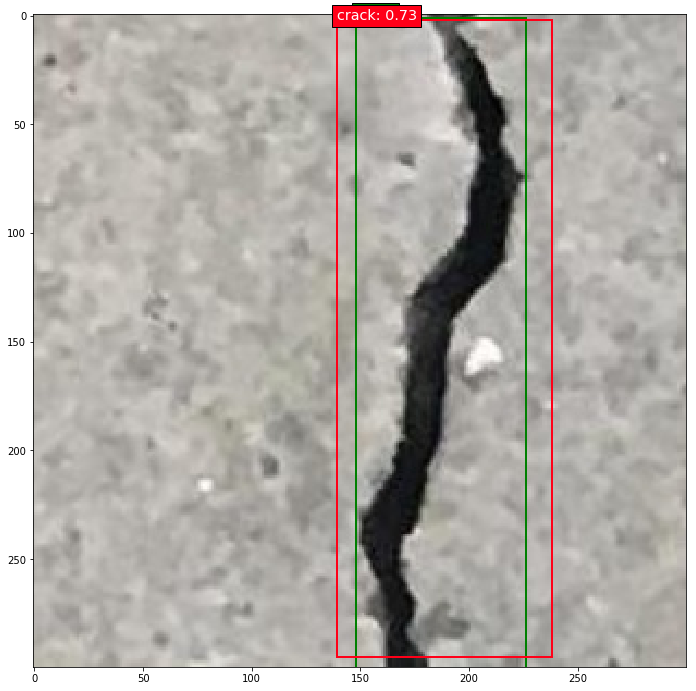

In [88]:
# 5: Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background','crack']

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

Loading images into memory: 100%|█████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 368.02it/s]


NameError: name 'convert_to_3_channels' is not defined